## Imports

In [41]:
from autograd import Value, populate_dataframe, build_causal_graph, draw_computational_graph
import numpy as np
import pandas as pd
from shapflow.flow import GraphExplainer, CausalLinks, build_feature_graph
import os

## Equation

In [42]:
def bubble_column_function(F1, F2, CT1, TI1, eps):
    Value.reset()

    # input variables
    F1      = Value(F1,             label='F1')
    F2      = Value(F2,             label='F2')
    CT1     = Value(CT1,            label='CT1')
    TI1     = Value(TI1,            label='TI1')
    eps     = Value(eps,            label='eps')

    # constants
    beta1   = Value(2.46291931e-3,   label='beta1')
    beta2   = Value(-6.61433312e-3,  label='beta2')
    beta3   = Value(-6.94002147e-14, label='beta3')
    beta4   = Value(-9.27760379e-3,  label='beta4')
    beta5   = Value(1.91506225e-2,   label='beta5')
    beta6   = Value(2.45071406e-2,   label='beta6')
    beta7   = Value(2.12414598e-2,   label='beta7')
    beta8   = Value(1.65748224e-2,   label='beta8')
    beta9   = Value(-1.65516588e-3,  label='beta9')
    b       = Value(0.08418511,       label='b')

    # f terms
    f1      = beta1 * (TI1)**2                ; f1.label = 'f1'
    f2      = beta2 * (-TI1)**2*(-F1)**2      ; f2.label = 'f2'
    f3      = beta3 * (-F1)/(eps)**2          ; f3.label = 'f3'
    f4      = beta4 * (-CT1)*(-F1)**2         ; f4.label = 'f4'
    f5      = beta5 * (-CT1)*(-F1)            ; f5.label = 'f5'
    f6      = beta6 * (F1)**2/(F1)            ; f6.label = 'f6'
    f7      = beta7 * (F2)                    ; f7.label = 'f7'
    f8      = beta8 * (-eps)*(CT1)            ; f8.label = 'f8'
    f9      = beta9 * (F1)*(-F2)**2*(F2)**2   ; f9.label = 'f9'

    y = f1 + f2 + f3 + f4 + f5 + f6 + f7 + f8 + f9 + b  ; y.label  = 'y'

    return y

## Generate and Prepare Data

In [43]:
# Checks if the populated dataframe already exists. Otherwise, it populates the dataframe (computationally expensive)
if os.path.exists('data/bubble column/bubble_column_populated_data.csv'):
    print('reading from data/bubble column/bubble_column_populated_data.csv')
    df = pd.read_csv('data/bubble column/bubble_column_populated_data.csv')
    X = df.drop(labels=['y'], axis=1)
    X[:5]
elif os.path.exists('data/bubble column/bubble_column_data.csv'):
    print('reading from data/bubble column/bubble_column_data.csv')
    df = pd.read_csv('data/bubble column/bubble_column_data.csv')

    # Delete unused vars
    X = df.drop(labels=['PI1', 'kla'], axis=1)

    # Standardize columns using z-score normalization
    X = (X - X.mean()) / X.std()

    # Populate the dataframe
    populate_dataframe(X, bubble_column_function)
    X[:5]
else:
    raise FileNotFoundError('Bubble column data file not found')

reading from data/bubble column/bubble_column_populated_data.csv


## Graph kla time dependency

In [44]:
bubble_column_with_timestamp_path = 'data/bubble column/bubble_column_with_timestamp.csv'
X_with_timestamp = pd.read_csv(bubble_column_with_timestamp_path)
X_with_timestamp[:5]

,Timestamp,kla,F1,F2,CT1,TI1,PI1,eps
0,0,0.020615,0.0,0.0,1.407795,23.564604,0.214363,0.0
1,2,0.020615,0.0,0.0,1.408442,23.564396,0.214366,0.0
2,4,0.020615,0.0,0.0,1.411740,23.564499,0.214353,0.0
3,6,0.020615,0.0,0.0,1.412369,23.563961,0.214363,0.0
4,8,0.020615,0.0,0.0,1.410815,23.564213,0.215173,0.0


<Axes: xlabel='Timestamp'>

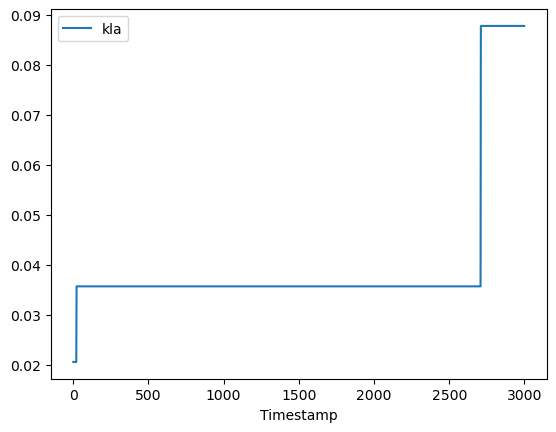

In [45]:
# Graph X_with_timestamp with the column Timestamp as the x axis and column kla as the y-axis
X_with_timestamp[:1500].plot(x='Timestamp', y='kla')

<Axes: xlabel='Timestamp'>

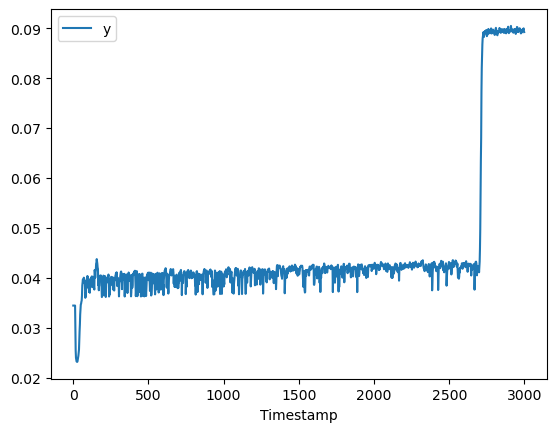

In [46]:
df['Timestamp'] = X_with_timestamp['Timestamp'].values

df[:1500].plot(x='Timestamp', y='y')

## Generate Computational Graph

Computational Graph Generated


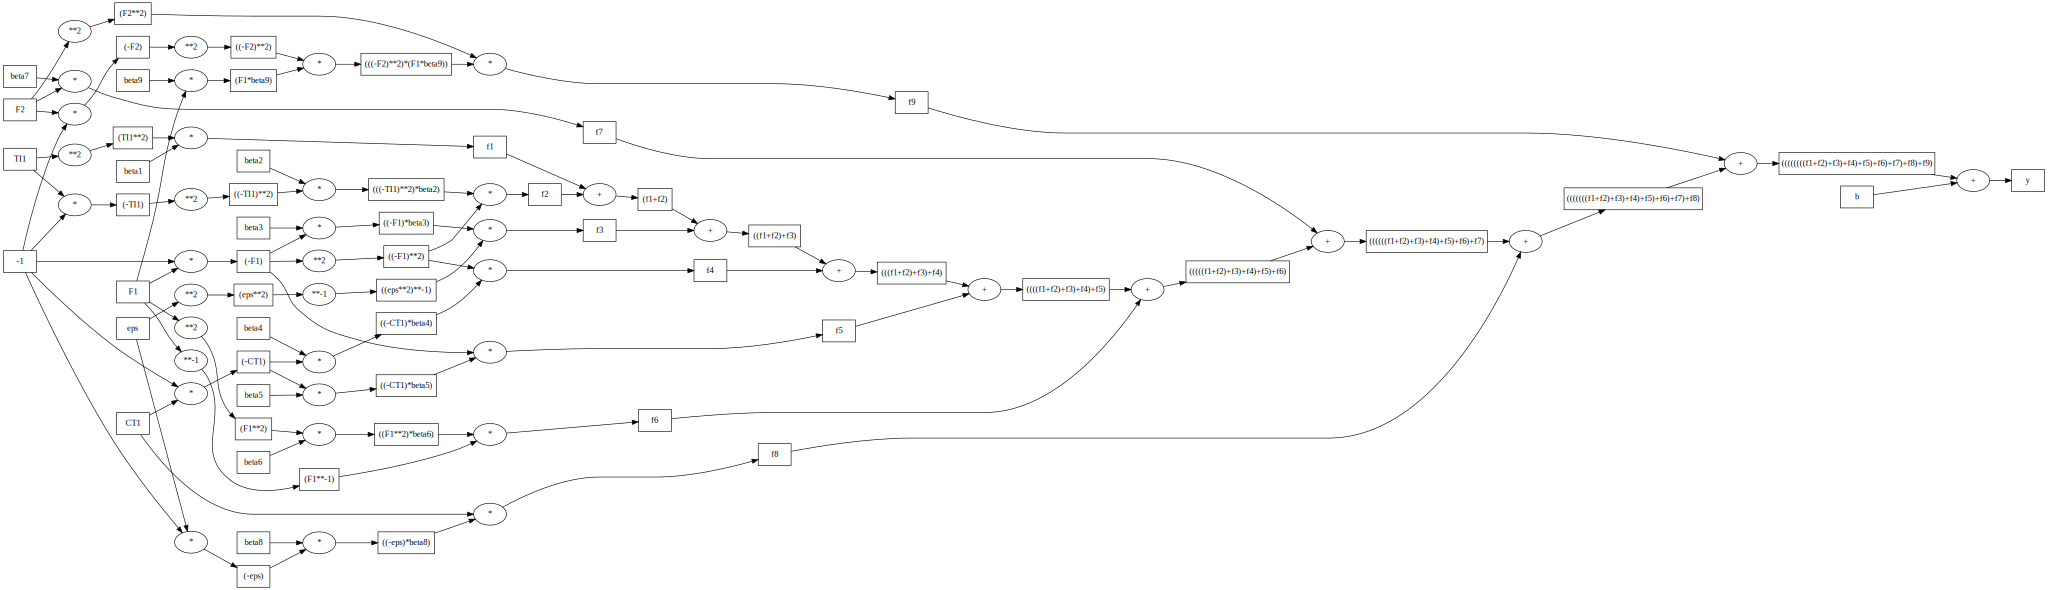

In [47]:
Value.reset()
y = bubble_column_function(0.1, 0.1, 0.1, 0.1, 0.1)
target_name = 'y'

computational_graph = draw_computational_graph(y, disable_data_field=True, disable_grad_field=True)
print("Computational Graph Generated")
computational_graph

## Build Causal Graph

[(['-1', 'F1'], ['(-F1)'], [<function op_to_function.<locals>.mul at 0x32b093600>]), (['(F2**2)', '(((-F2)**2)*(F1*beta9))'], ['f9'], [<function op_to_function.<locals>.mul at 0x32b093560>]), (['((eps**2)**-1)', '((-F1)*beta3)'], ['f3'], [<function op_to_function.<locals>.mul at 0x32b0936a0>]), (['beta9', 'F1'], ['(F1*beta9)'], [<function op_to_function.<locals>.mul at 0x32b0934c0>]), (['beta2', '((-TI1)**2)'], ['(((-TI1)**2)*beta2)'], [<function op_to_function.<locals>.mul at 0x32b093420>]), (['F2'], ['(F2**2)'], [functools.partial(<function op_to_function.<locals>.pow at 0x32b0931a0>, exponent=2)]), (['CT1', '-1'], ['(-CT1)'], [<function op_to_function.<locals>.mul at 0x32b093380>]), (['-1', 'F2'], ['(-F2)'], [<function op_to_function.<locals>.mul at 0x32b093240>]), (['((-CT1)*beta5)', '(-F1)'], ['f5'], [<function op_to_function.<locals>.mul at 0x32b0932e0>]), (['(((((f1+f2)+f3)+f4)+f5)+f6)', 'f7'], ['((((((f1+f2)+f3)+f4)+f5)+f6)+f7)'], [<function op_to_function.<locals>.add at 0x32b

0it [00:00, ?it/s]


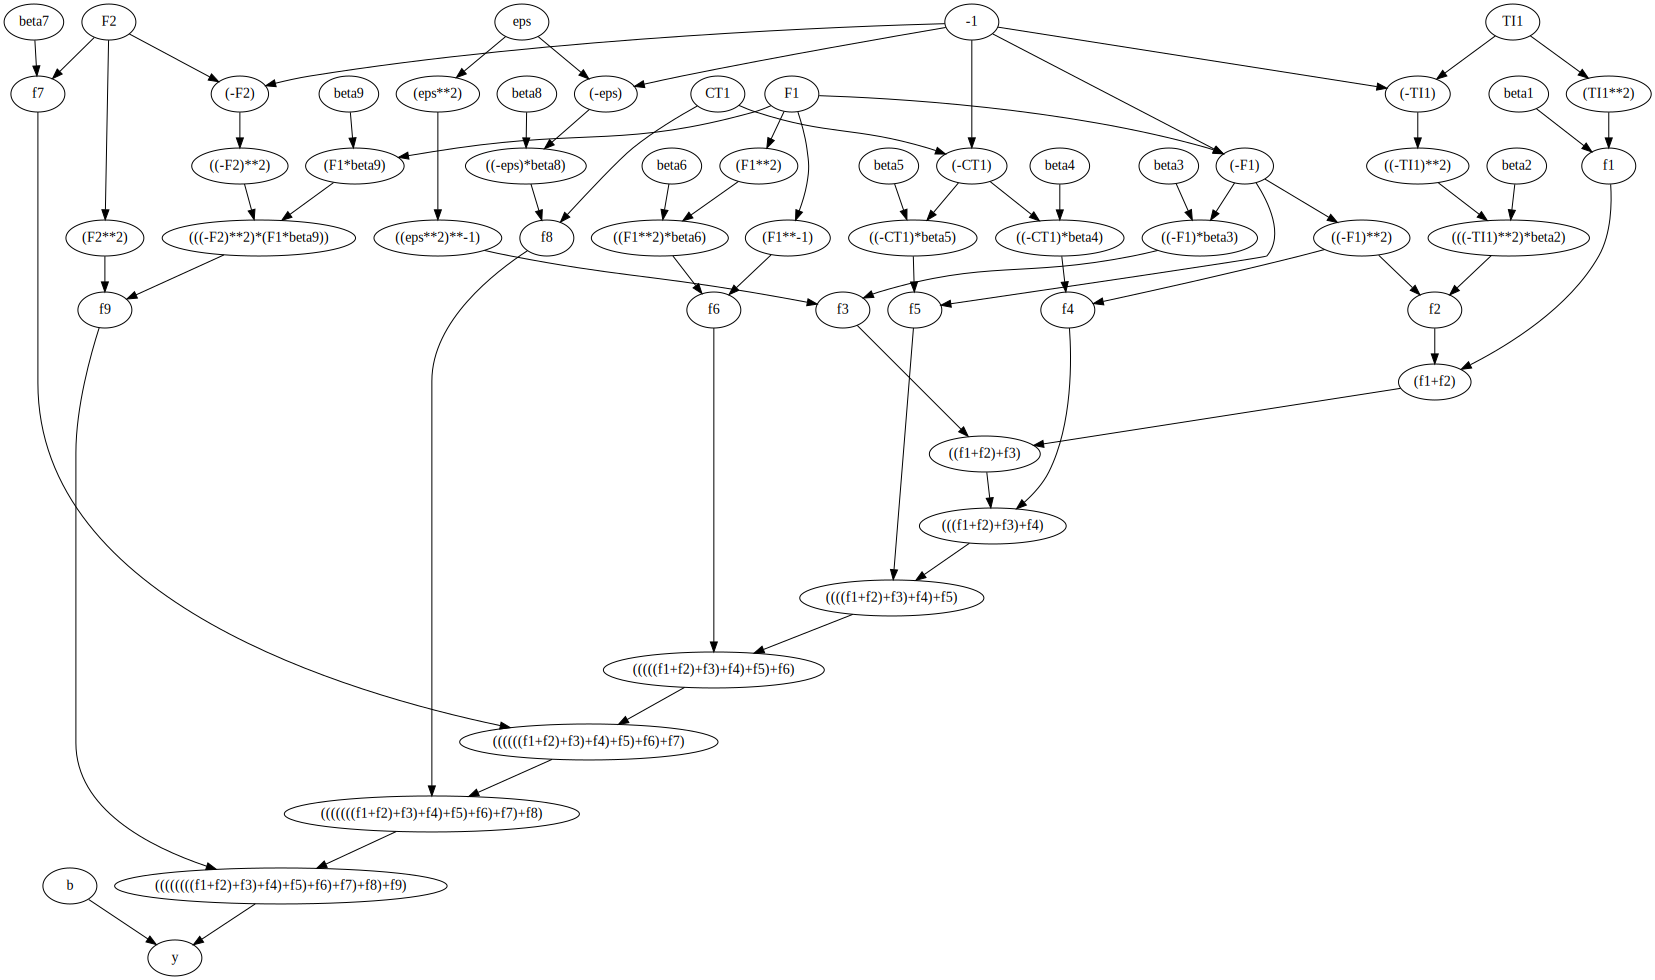

In [48]:
y = bubble_column_function(0.1, 0.1, 0.1, 0.1, 0.1)
target_name = 'y'


causal_graph = build_causal_graph(y, X, target_name)
causal_graph.draw(rankdir='TB')

## Shapley Flow Analysis

bruteforce sampling: 100%|██████████| 100/100 [00:00<00:00, 307.80it/s]


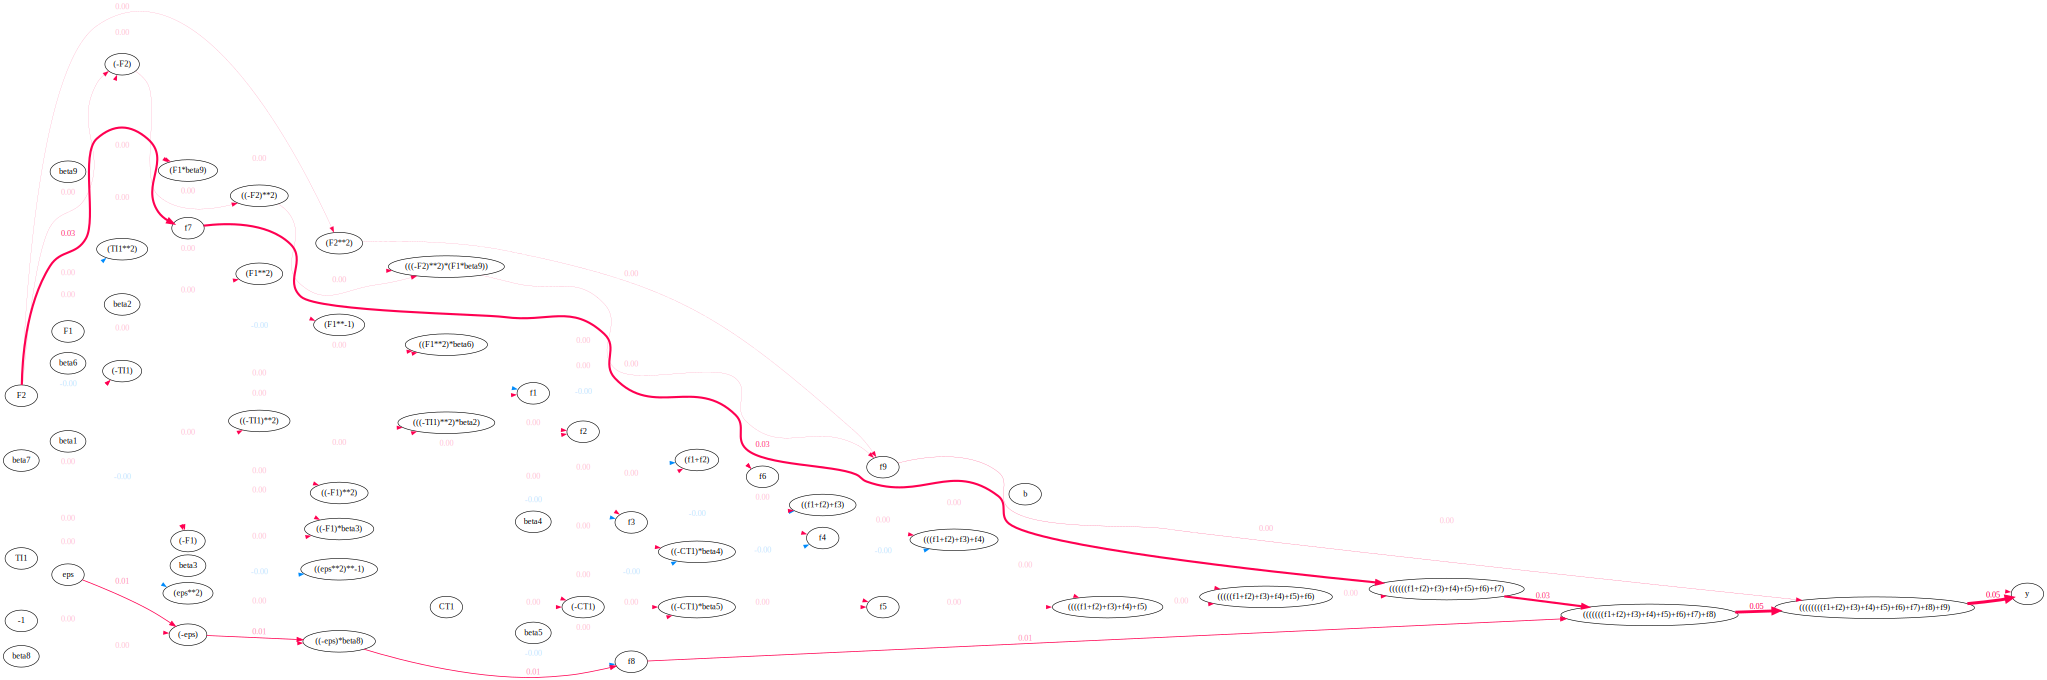

In [49]:
# nsamples = 100 # number of foreground samples to explain
nruns = 100 # number of monte carlo samples
sample_ind = 0

# set bg to the 1243th row of bubble column spreadsheet. We index at 1241 because X is 0-indexed and the first row of the spreadsheet just has column names. Thus, our index is offset by -2.
bg = X.iloc[1241:1242]

# set fg to the 1363rd row of bubble column spreadsheet. We index at 1361 for the same reason as bg
fg = X.iloc[1361:1362]

# NOTE: we select specifically these two points as our background and foreground because the bubble column kla value massively changes between these two points.

cf_flow = GraphExplainer(causal_graph, bg, nruns=nruns).shap_values(fg, rankdir='LR')
cf_flow.fold_noise = True
shapflow_graph = cf_flow.draw(sample_ind, show_fg_val=False)#, rankdir='TB')

## Simplified Shapley Flow With Only f Terms

0it [00:00, ?it/s]

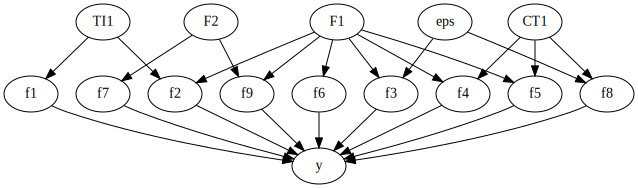

bruteforce sampling: 100%|██████████| 100/100 [00:00<00:00, 1462.89it/s]


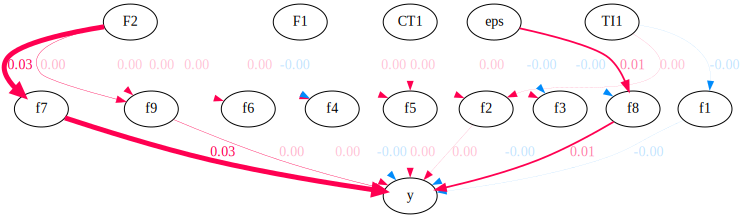

In [50]:
# constants
beta1   = 2.46291931e-3
beta2   = -6.61433312e-3
beta3   = -6.94002147e-14
beta4   = -9.27760379e-3
beta5   = 1.91506225e-2
beta6   = 2.45071406e-2
beta7   = 2.12414598e-2
beta8   = 1.65748224e-2
beta9   = -1.65516588e-3
b       = 0.08418511

# f terms
# f1      = beta1 * (TI1)**2
# f2      = beta2 * (-TI1)**2*(-F1)**2
# f3      = beta3 * (-F1)/(eps)**2
# f4      = beta4 * (-CT1)*(-F1)**2
# f5      = beta5 * (-CT1)*(-F1)
# f6      = beta6 * (F1)**2/(F1)
# f7      = beta7 * (F2)
# f8      = beta8 * (-eps)*(CT1)
# f9      = beta9 * (F1)*(-F2)**2*(F2)**2

causal_links = CausalLinks()
target_name = 'y'
feature_names = list(X.columns)
X_with_only_f_terms = X[['F1', 'F2', 'CT1', 'TI1', 'eps', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']]
causal_links.add_causes_effects(
    ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9'],
    target_name,
    lambda *args: sum(args) + b,
)
causal_links.add_causes_effects(['TI1'], ['f1'], lambda TI1: beta1 * (TI1)**2)
causal_links.add_causes_effects(['TI1', 'F1'], ['f2'], lambda TI1, F1 : beta2 * (-TI1)**2*(-F1)**2)
causal_links.add_causes_effects(['F1', 'eps'], ['f3'], lambda F1, eps : beta3 * (-F1)/(eps)**2)
causal_links.add_causes_effects(['CT1', 'F1'], ['f4'], lambda CT1, F1 : beta4 * (-CT1)*(-F1)**2)
causal_links.add_causes_effects(['CT1', 'F1'], ['f5'], lambda CT1, F1 : beta5 * (-CT1)*(-F1))
causal_links.add_causes_effects(['F1'], ['f6'], lambda F1 : beta6 * (F1)**2/(F1))
causal_links.add_causes_effects(['F2'], ['f7'], lambda F2 : beta7 * (F2))
causal_links.add_causes_effects(['eps', 'CT1'], ['f8'], lambda eps, CT1 : beta8 * (-eps)*(CT1))
causal_links.add_causes_effects(['F1', 'F2'], ['f9'], lambda F1, F2 : beta9 * (F1)*(-F2)**2*(F2)**2)

causal_graph_simplified = build_feature_graph(X_with_only_f_terms, causal_links, target_name=target_name)
causal_graph_simplified.draw(rankdir='TB')

nruns = 100
sample_ind = 0
bg = X_with_only_f_terms.iloc[1241:1242]
fg = X_with_only_f_terms.iloc[1361:1362]

cf_flow = GraphExplainer(causal_graph_simplified, bg, nruns=nruns).shap_values(fg, rankdir='TB')

cf_flow.fold_noise = True
shapflow_graph_simplified = cf_flow.draw(sample_ind, show_fg_val=False)#, rankdir='TB')

## Save Results

In [51]:
dir_name = 'bubble_column'
save_dir = f'results/{dir_name}'
os.makedirs(save_dir, exist_ok=True)

computational_graph.render(os.path.join(save_dir, 'computational_graph'), format='png')
causal_graph.to_graphviz(rankdir='LR').draw(
    path=os.path.join(save_dir, 'causal_graph.png'),
    format='png',
    prog='dot'
)
shapflow_graph.draw(
    path=os.path.join(save_dir, 'shapflow_graph.png'),
    format='png',
    prog='dot'
)
causal_graph_simplified.to_graphviz(rankdir='LR').draw(
    path=os.path.join(save_dir, 'causal_graph_simplified.png'),
    format='png',
    prog='dot'
)
shapflow_graph_simplified.draw(
    path=os.path.join(save_dir, 'shapflow_graph_simplified.png'),
    format='png',
    prog='dot'
)

print("All graphs have been saved to:", save_dir)

All graphs have been saved to: results/bubble_column
